<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/page_satus_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3

Reading package lists...
Building dependency tree...
Reading state information...
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libmecab-dev is already the newest version (0.996-5).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [0]:
import sys, pickle, os, json, keras, time, re
from sklearn.model_selection import KFold
from keras.datasets import boston_housing
from keras.models import Model,model_from_json
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.datasets import mnist
from keras import models
from keras import layers
import numpy as np
from google.colab import files
from keras.metrics import categorical_accuracy
from scipy.stats import zscore
import random
import pandas as pd
import matplotlib.pyplot as plt
import MeCab
mecab = MeCab.Tagger("-Owakati")

In [0]:
def save_text_tokenizer(tokenizer,file_name):
  # saving
  with open(file_name+".pickle", 'wb') as handle:
      pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_text_tokenizer(file_name):
  # loading
  with open(file_name+".pickle", 'rb') as handle:
      return pickle.load(handle)

In [75]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
base_dir = "/content/gdrive/My Drive/data/status_filter/"
!ls "/content/gdrive/My Drive/data/status_filter/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data  error.csv  page_st.csv  text_token.pickle  weights.best.h5


In [76]:
page_file_name = 'page_st.csv'
target_columns = ['label','text']
dtype ={'label':str,'text':str} 
raw_df = pd.read_csv(base_dir + page_file_name,sep=',',error_bad_lines=False, dtype=dtype,engine='python')
# raw_df2 = pd.read_csv(base_dir + 'new_status.csv',sep=',',error_bad_lines=False, dtype=dtype,engine='python')
# raw_df = pd.concat([raw_df,raw_df2],axis=0)
raw_df = raw_df[~raw_df.duplicated()]
print('raw_df',raw_df.shape)
print(raw_df.columns)
print(raw_df['label'].value_counts())
raw_df.to_csv(base_dir+'page_st.csv',index=False)

raw_df (2232, 3)
Index(['label', 'url', 'text'], dtype='object')
no        1425
stock      529
list       135
top         88
login       25
block       19
except      11
Name: label, dtype: int64


In [0]:
def change_label(label):
  if label != 'stock' :label = 'no'
  return label

raw_df['label'] = raw_df['label'].apply(lambda x : change_label(x))

In [78]:
raw_df = raw_df.dropna()
raw_df = raw_df.sample(frac=1)
print(raw_df["label"].value_counts())
print('raw_df',raw_df.shape)
print(raw_df.columns)


no       1703
stock     529
Name: label, dtype: int64
raw_df (2232, 3)
Index(['label', 'url', 'text'], dtype='object')


In [79]:
text = 'sorry we can t this product page 　　re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 ました 売り 切れ ページ 見つかり ません この 製品 もう 入手 できません'
def prepro(text:str)->list:
  line = ""
  text = mecab.parse(str(text)).replace("↵"," ")
  text = re.sub('{.*}','',text)
  words = text.lower()
  return words
prepro(text)


'sorry we can t this product page \u3000 \u3000 re sold out 404 whoops our bad it gone out of stock 切れ 在庫 なし 完売 まし た 売り 切れ ページ 見つかり ませ ん この 製品 もう 入手 でき ませ ん \n'

In [80]:
raw_df['edit_text'] = raw_df['text'].apply(lambda x : prepro(x))
regex = "^(sorry.? (we can.t|this (product|page)))|^(sorry we.re sold out)|^(404|whoops, our bad...|it.s gone|out of stock|sold out|在庫切れ|在庫なし|完売しました|売り切れ|ページが見つかりません.*|この製品はもう入手できない.|ci scusiamo per l'inconveniente.|sorry!|back to our favs)$|(((product|page|item|requested) (is |was )?)(not found|no longer|sold out|out of stock|not available))|(re (sorry|sold out)|(ご購入いただけません)|(404 error))|^(sold out\\s*){3,}|ARTICLE.*EN LIGNE|^so sorry.*|404 page not|Don.t Cry|.*is out of stock.|articolo non disponibile";
p = re.compile(regex)
raw_df['flag'] = raw_df['text'].apply(lambda x : 0 if p.match(x) == None else 1)
raw_df['edit_text'] = raw_df['edit_text'].fillna("")

token = keras.preprocessing.text.Tokenizer(num_words=250)
token.fit_on_texts(raw_df['edit_text'].values)
save_text_tokenizer(token,base_dir + 'text_token')
X = token.texts_to_matrix(raw_df['edit_text'].values)
flag = np.array(raw_df['flag'])
flag = flag.reshape(len(flag),1)
print('flag',flag.shape,'X',X.shape)
# X = np.concatenate((flag,X),axis=1)

# X = flag
# text_len = len(X[0])
# print(f'text_len:{text_len} samples:{len(X)}')
print('word_count',len(token.word_counts))
print(token.word_counts)
print(token.word_index)
X = np.array(X)
print('X',X.shape)

flag (2232, 1) X (2232, 250)
word_count 27026
OrderedDict([('united', 711), ('states', 361), ('help', 1063), ('log', 192), ('in', 4452), ('0', 2413), ('latest', 463), ('brands', 480), ('clothing', 706), ('footwear', 64), ('accessories', 701), ('grooming', 39), ('gifts', 266), ('sale', 1148), ('launches', 23), ('blog', 241), ('free', 1821), ('shipping', 2504), ('on', 3399), ('orders', 1148), ('over', 534), ('250', 75), ('import', 37), ('duties', 96), ('paid', 16), ('2', 1404), ('3', 1303), ('day', 368), ('fedex', 27), ('delivery', 1147), ('404', 348), ('sorry', 278), ('this', 2053), ('page', 1581), ('could', 170), ('not', 1974), ('be', 961), ('found', 695), ('it', 1327), ('looks', 81), ('like', 874), ('you', 4217), ('’', 709), ('re', 540), ('looking', 312), ('for', 2806), ('might', 132), ('have', 553), ('been', 207), ('removed', 27), ('changed', 32), ('or', 1182), ('is', 1567), ('temporarily', 44), ('unavailable', 93), ('go', 445), ('to', 7716), ('homepage', 173), ('sign', 1631), ('up',

In [0]:
index2word =  {i+1:key for i, key in enumerate(token.word_index)}
# index2word

In [0]:
# label_token = keras.preprocessing.text.Tokenizer()
# label_token.fit_on_texts(raw_df['label'].values)
# y = label_token.texts_to_matrix(raw_df['label'].values)
# label_len = len(label_token.word_counts) + 1

y = to_categorical(raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0))
# print('word_index',label_token.word_index)
# print('label_len',label_len)
# print('y shape',y.shape)

In [0]:
raw_df['true'] = raw_df['label'].apply(lambda x : 1 if x == 'stock' else 0)

In [84]:

def get_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Embedding(1500, 64, input_length= len(X[0])))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(512,activation='relu'))
  model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(512,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(256,activation='relu'))
  # model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(2,activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer ='adam',metrics=['categorical_accuracy'])
  return model

get_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 250, 64)           96000     
_________________________________________________________________
dropout_70 (Dropout)         (None, 250, 64)           0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 16000)             0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 16000)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               8192512   
_________________________________________________________________
dropout_72 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 1026      
Total para

In [85]:

EPOCHS = 50
BATCH_SIZE = 32

# stop when score is not improve
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=20)

# save best score
filepath = base_dir+"weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=0, save_best_only=True, mode='max')

# reduce 
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
callbacks_list = [checkpoint,early_stopping,reduce]

scores = []
historys = []
kf = KFold(n_splits=4, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
  model = get_model()
  history = model.fit(X[train_index], y[train_index], validation_split=0.2,verbose=0,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks=callbacks_list)
  historys.append(history)
  score = model.evaluate(X[test_index],y[test_index])
  print(score)
  scores.append(score)

load_model = keras.models.load_model(filepath)
score = load_model.evaluate(X[test_index],y[test_index])
print('Test best loss:', score[0])
print('Test best accuracy:', score[1])

558/558 [==============================] - 0s 92us/step
[0.37978704773076544, 0.9229390674594483]
558/558 [==============================] - 0s 88us/step
[0.3458477071457518, 0.9247311827956989]
558/558 [==============================] - 0s 92us/step
[0.23672619208735596, 0.942652329749104]
558/558 [==============================] - 0s 91us/step
[0.2530936465254821, 0.9462365593534217]
558/558 [==============================] - 1s 2ms/step
Test best loss: 0.210426414205182
Test best accuracy: 0.9480286740487621


In [86]:
print("KFlod")
print("Sample",len(X))
print("Score",pd.DataFrame(scores).mean()[1]*100)
print("Std",pd.DataFrame(scores).std()[1]*100)


KFlod
Sample 2232
Score 93.41397848394182
Std 1.2010734597643604


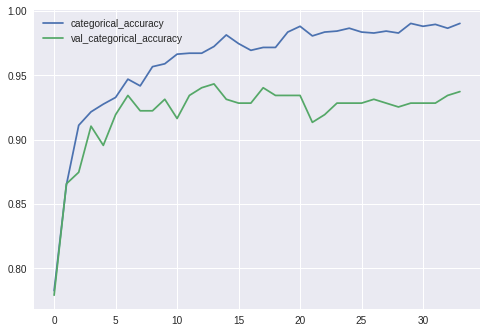

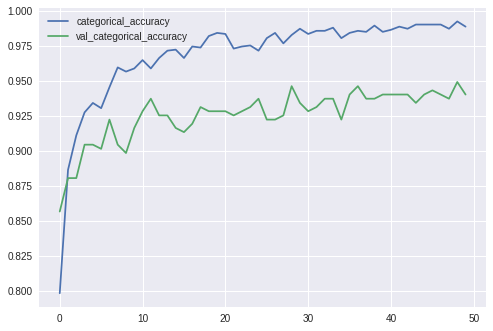

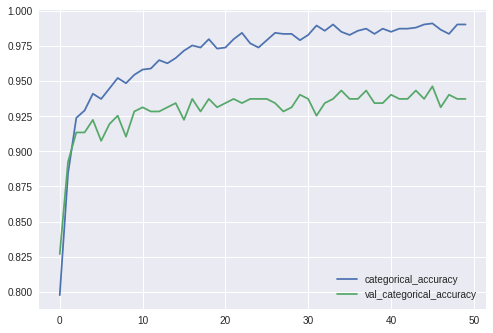

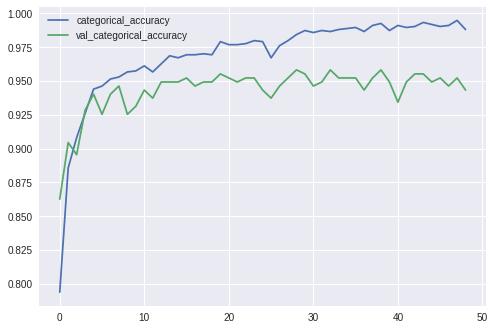

In [87]:
for i in range(len(historys)):
  df = pd.DataFrame(historys[i].history)
#   df.filter(regex=('loss*')).plot()
  df.filter(regex=('accuracy$')).plot()
  
plt.show()
  

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


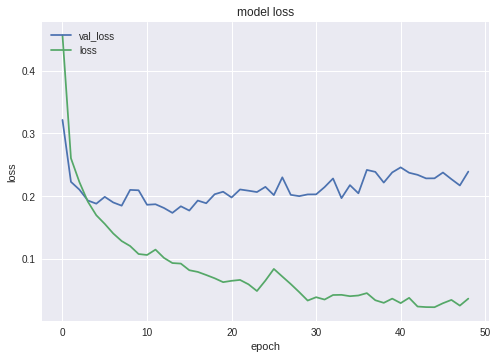

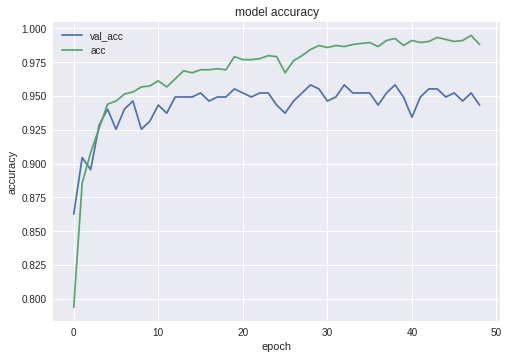

In [88]:

import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc', 'acc'], loc='upper left')
plt.show()

In [89]:
len(test_index)

558

In [0]:
raw_df['pred'] = load_model.predict(X).argmax(axis=1)

In [91]:
error_df = raw_df.query("true != pred")
print(len(error_df))
error_df[['label','true','pred','url','text']].to_csv(base_dir+'error.csv',index=False)

51
